In [ ]:
import zipfile
import os

# Define paths
expw_zip_path = "/content/ExpW_sorted_gray.zip"  # Update this if needed
expw_extract_path = "/content/ExpW_sorted_gray"

# Extract dataset
with zipfile.ZipFile(expw_zip_path, 'r') as zip_ref:
    zip_ref.extractall(expw_extract_path)

print("✅ ExpW Sorted Grayscale Dataset Extracted Successfully!")
os.listdir(expw_extract_path)  # Check extracted files

✅ ExpW Sorted Grayscale Dataset Extracted Successfully!


['ExpW_sorted_gray']

In [ ]:
# Define paths
zip_path = "/content/combined_dataset.zip"  # Update this if needed
extract_path = "/content/combined_dataset"

# Extract dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Combined Dataset Extracted Successfully!")
os.listdir(extract_path)  # Check extracted files

✅ Combined Dataset Extracted Successfully!


['__MACOSX', 'combined_dataset']

In [ ]:
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import zipfile
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense, Dropout, LSTM, Flatten, Concatenate)

# ✅ Ensure GPU is Available
print("✅ GPU Available:", tf.config.list_physical_devices('GPU'))


# 📌 Dataset Paths
TRAIN_DIR_1 = "/content/combined_dataset/train"
VAL_DIR_1 = "/content/combined_dataset/validation"

TRAIN_DIR_2 = "/content/ExpW_sorted_gray/ExpW_sorted_gray/ExpW_train"
VAL_DIR_2 = "/content/ExpW_sorted_gray/ExpW_sorted_gray/ExpW_val"

# 📌 Image Parameters
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
EPOCHS = 50

# 📌 Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# ✅ Load Combined Dataset
train_generator_1 = train_datagen.flow_from_directory(
    TRAIN_DIR_1, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='grayscale', shuffle=True
)
val_generator_1 = val_datagen.flow_from_directory(
    VAL_DIR_1, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='grayscale', shuffle=False
)

# ✅ Load ExpW Dataset
train_generator_2 = train_datagen.flow_from_directory(
    TRAIN_DIR_2, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='grayscale', shuffle=True
)
val_generator_2 = val_datagen.flow_from_directory(
    VAL_DIR_2, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='grayscale', shuffle=False
)

# ✅ Merge Datasets
def combined_generators(gen1, gen2):
    while True:
        batch1 = next(gen1)
        batch2 = next(gen2)
        yield (tf.concat([batch1[0], batch2[0]], axis=0), tf.concat([batch1[1], batch2[1]], axis=0))

train_generator = combined_generators(train_generator_1, train_generator_2)
val_generator = combined_generators(val_generator_1, val_generator_2)

# 📌 Optimized Model (EfficientNet + LSTM)
def build_optimized_model(input_shape=(48, 48, 1)):
    inputs = Input(shape=input_shape)

    # Convert grayscale to 3-channel (for EfficientNet)
    x = Conv2D(3, (1, 1), activation=None)(inputs)

    # EfficientNet for Feature Extraction
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(48, 48, 3), weights="imagenet")
    x = base_model(x, training=False)

    # Global Pooling + Flatten
    x1 = GlobalAveragePooling2D()(x)
    x2 = Flatten()(x)
    x = Concatenate()([x1, x2])

    # LSTM for Sequential Learning
    x = tf.keras.layers.Reshape((1, -1))(x)
    x = LSTM(128, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    # Fully Connected Layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output Layer (7 Classes)
    output = Dense(7, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    return model

# ✅ Compile Model
model = build_optimized_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

# 📌 Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_combined_model.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# ✅ Train Model on Combined Dataset
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=min(len(train_generator_1), len(train_generator_2)),  # Ensure both generators have enough samples
    validation_steps=min(len(val_generator_1), len(val_generator_2)),
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping, checkpoint]
)

# ✅ Save Model
model.save("final_fine_tuned_combined.keras")

print("✅ Training Completed Successfully!")

✅ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 47625 images belonging to 7 classes.
Found 0 images belonging to 7 classes.
Found 66796 images belonging to 7 classes.
Found 16703 images belonging to 7 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2934 - loss: 1.7351

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ResEmoteNet-main.zip -d /content/

Archive:  /content/drive/MyDrive/ResEmoteNet-main.zip
fabbe680427b0da00611ed016aa3c804d072bd33
   creating: /content/ResEmoteNet-main/
  inflating: /content/ResEmoteNet-main/.gitattributes  
 extracting: /content/ResEmoteNet-main/.gitignore  
  inflating: /content/ResEmoteNet-main/CITATION.cff  
  inflating: /content/ResEmoteNet-main/LICENSE  
  inflating: /content/ResEmoteNet-main/README.md  
  inflating: /content/ResEmoteNet-main/ResEmoteNet -  Facial Emotion Recognition.pdf  
   creating: /content/ResEmoteNet-main/approach/
  inflating: /content/ResEmoteNet-main/approach/ResEmoteNet.py  
  inflating: /content/ResEmoteNet-main/approach/baseline.py  
  inflating: /content/ResEmoteNet-main/approach/baseline_se.py  
  inflating: /content/ResEmoteNet-main/approach/resnet.py  
  inflating: /content/ResEmoteNet-main/approach/vgg.py  
  inflating: /content/ResEmoteNet-main/classification_scores_valid.csv  
  inflating: /content/ResEmoteNet-main/cross_db_test.py  
   creating: /content/ResEm

In [ ]:
!unzip /content/drive/MyDrive/Final_Dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Final_Dataset/val/neutral/dup_-4545010528434674653.jpg  
  inflating: /content/Final_Dataset/val/neutral/ffhq_4558.jpg  
  inflating: /content/Final_Dataset/val/neutral/-5362954341050731243.jpg  
  inflating: /content/Final_Dataset/val/neutral/ffhq_5646.jpg  
  inflating: /content/Final_Dataset/val/neutral/ffhq_5120.jpg  
  inflating: /content/Final_Dataset/val/neutral/dup_1254681219349936285.jpg  
  inflating: /content/Final_Dataset/val/neutral/-3257662853857545991.jpg  
  inflating: /content/Final_Dataset/val/neutral/8665243088231157976.jpg  
  inflating: /content/Final_Dataset/val/neutral/ffhq_5108.jpg  
  inflating: /content/Final_Dataset/val/neutral/image0003805.jpg  
  inflating: /content/Final_Dataset/val/neutral/ffhq_457.jpg  
  inflating: /content/Final_Dataset/val/neutral/ffhq_4564.jpg  
  inflating: /content/Final_Dataset/val/neutral/2672114162641710346.jpg  
  inflating: /content/Final_Dataset/val/neut

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report
import os

# Change to project directory (from original script context)
os.chdir('/content/ResEmoteNet')
from approach.ResEmoteNet import ResEmoteNet  # Import ResEmoteNet architecture

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Augmentation & Preprocessing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Match original input format
    transforms.Resize((48, 48)),                 # Resize to expected input size
    transforms.RandomHorizontalFlip(),           # Augmentation for generalization
    transforms.RandomRotation(10),               # Slight rotation for robustness
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load Dataset (Using original dataset directories)
base_path = "/content/Final_Dataset"  # Original dataset directory
train_dataset = datasets.ImageFolder(f"{base_path}/train", transform=transform)
val_dataset = datasets.ImageFolder(f"{base_path}/val", transform=transform)
test_dataset = datasets.ImageFolder(f"{base_path}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Load Pre-trained Model
pretrained_model_path = "/content/drive/MyDrive/best_ResEmoteNet_finetuned.pth"  # Adjust to your pre-trained model path
model = ResEmoteNet().to(device)
model.load_state_dict(torch.load(pretrained_model_path, weights_only=True))
print("Pre-trained Model Loaded Successfully")

# Freeze Initial Layers
# Assuming ResEmoteNet has layers like res_block1 (adjust based on actual architecture)
for param in model.res_block1.parameters():
    param.requires_grad = False
print("Initial layers frozen for fine-tuning")

# Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

# Fine-Tuning Function with Early Stopping
def fine_tune_model(model, train_loader, val_loader, epochs=50, patience=5):
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        # Validation Phase
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                correct += (outputs.argmax(1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = correct / len(val_loader.dataset)

        # Print Progress
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Update Learning Rate
        scheduler.step(val_loss)

        # Save Best Model and Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = "/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth"
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved to {save_path} with Val Acc: {best_val_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

# Run Fine-Tuning
print("Starting fine-tuning...")
fine_tune_model(model, train_loader, val_loader, epochs=50, patience=5)

# Evaluate on Test Set with Detailed Metrics
model.load_state_dict(torch.load("/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth", weights_only=True))
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = sum([1 if all_preds[i] == all_labels[i] else 0 for i in range(len(all_preds))]) / len(all_preds)
print(f"🔥 Final Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pre-trained Model Loaded Successfully
Initial layers frozen for fine-tuning
Starting fine-tuning...
Epoch 1/50: Train Loss: 0.3560, Train Acc: 0.8822, Val Loss: 1.2280, Val Acc: 0.6801, LR: 0.000100
✅ Best model saved to /content/drive/MyDrive/best_finetuned_ResEmoteNet.pth with Val Acc: 0.6801
Epoch 2/50: Train Loss: 0.3174, Train Acc: 0.8909, Val Loss: 1.2482, Val Acc: 0.6851, LR: 0.000100
✅ Best model saved to /content/drive/MyDrive/best_finetuned_ResEmoteNet.pth with Val Acc: 0.6851
Epoch 3/50: Train Loss: 0.3022, Train Acc: 0.8968, Val Loss: 1.3187, Val Acc: 0.6874, LR: 0.000100
✅ Best model saved to /content/drive/MyDrive/best_finetuned_ResEmoteNet.pth with Val Acc: 0.6874
Epoch 4/50: Train Loss: 0.2933, Train Acc: 0.8988, Val Loss: 1.3184, Val Acc: 0.6873, LR: 0.000100
Epoch 5/50: Train Loss: 0.2819, Train Acc: 0.9028, Val Loss: 1.2939, Val Acc: 0.6940, LR: 0.000100
✅ Best model saved to /content/drive/MyDrive/best_finetuned_ResEmoteNet.pth with Val Acc: 0.6940
Epoch 6/50: Train

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report
from collections import Counter
import os

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Define Paths (Adjust these to your setup)
train_dir = '/content/Final_Dataset/train'  # Path to training data
val_dir = '/content/Final_Dataset/val'      # Path to validation data
test_dir = '/content/Final_Dataset/test'    # Path to test data
pretrained_model_path = '/content/drive/MyDrive/best_ResEmoteNet_finetuned.pth'  # Path to pre-trained model
save_path = '/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth'         # Where to save fine-tuned model

# Enhanced Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.Resize((48, 48)),                  # Resize to model's input size
    transforms.RandomHorizontalFlip(),            # Flip for generalization
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Random translation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),        # Adjust lighting
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Standard Transforms for Validation and Test (No augmentation)
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Calculate Class Weights for Imbalance
class_counts = Counter(train_dataset.targets)
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Load Pre-trained Model (Adjust import as needed)
from approach.ResEmoteNet import ResEmoteNet  # Replace with your actual module path
model = ResEmoteNet().to(device)
model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
print("✅ Pre-trained Model Loaded Successfully")

# Freeze Initial Layers (Adjust based on your model architecture)
for param in model.res_block1.parameters():  # Example: freeze first residual block
    param.requires_grad = False
print("🔒 Initial layers frozen for fine-tuning")

# Loss Function with Class Weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer and Scheduler
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

# Fine-Tuning Function with Early Stopping
def fine_tune_model(model, train_loader, val_loader, epochs=50, patience=5):
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        # Validation Phase
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                correct += (outputs.argmax(1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = correct / len(val_loader.dataset)

        # Print Progress
        print(f"📌 Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Update Learning Rate
        scheduler.step(val_loss)

        # Save Best Model and Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved to {save_path} with Val Acc: {best_val_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("🛑 Early stopping triggered!")
                break

# Run Fine-Tuning
print("🚀 Starting fine-tuning...")
fine_tune_model(model, train_loader, val_loader, epochs=50, patience=5)

# Evaluate on Test Set with Detailed Metrics
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = sum([1 if all_preds[i] == all_labels[i] else 0 for i in range(len(all_preds))]) / len(all_preds)
print(f"🔥 Final Test Accuracy: {test_acc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

🔥 Using device: cuda


<ipython-input-9-b6ef57a451d5>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model_path, map_location=device))


✅ Pre-trained Model Loaded Successfully
🔒 Initial layers frozen for fine-tuning
🚀 Starting fine-tuning...
📌 Epoch 1/50: Train Loss: 0.7277, Train Acc: 0.7537, Val Loss: 0.9579, Val Acc: 0.7028, LR: 0.000100
✅ Best model saved to /content/drive/MyDrive/best_finetuned_ResEmoteNet.pth with Val Acc: 0.7028
📌 Epoch 2/50: Train Loss: 0.6533, Train Acc: 0.7738, Val Loss: 0.9820, Val Acc: 0.7046, LR: 0.000100
✅ Best model saved to /content/drive/MyDrive/best_finetuned_ResEmoteNet.pth with Val Acc: 0.7046
📌 Epoch 3/50: Train Loss: 0.6243, Train Acc: 0.7835, Val Loss: 1.0615, Val Acc: 0.6959, LR: 0.000100
📌 Epoch 4/50: Train Loss: 0.5926, Train Acc: 0.7943, Val Loss: 1.0549, Val Acc: 0.7052, LR: 0.000100
✅ Best model saved to /content/drive/MyDrive/best_finetuned_ResEmoteNet.pth with Val Acc: 0.7052
📌 Epoch 5/50: Train Loss: 0.5744, Train Acc: 0.8001, Val Loss: 1.0903, Val Acc: 0.6998, LR: 0.000100
📌 Epoch 6/50: Train Loss: 0.4970, Train Acc: 0.8273, Val Loss: 1.0950, Val Acc: 0.7086, LR: 0.0000

<ipython-input-9-b6ef57a451d5>:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=device))


🔥 Final Test Accuracy: 0.6820

📊 Classification Report:
              precision    recall  f1-score   support

       angry       0.61      0.68      0.64      3582
     disgust       0.73      0.60      0.66      2505
        fear       0.63      0.56      0.59      3534
       happy       0.82      0.84      0.83      4841
     neutral       0.67      0.70      0.68      4521
         sad       0.62      0.58      0.60      3882
    surprise       0.67      0.74      0.70      3640

    accuracy                           0.68     26505
   macro avg       0.68      0.67      0.67     26505
weighted avg       0.68      0.68      0.68     26505



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report
from collections import Counter
import os

os.chdir('/content/ResEmoteNet')
from approach.ResEmoteNet import ResEmoteNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Data transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
base_path = "/content/Final_Dataset"
train_dataset = datasets.ImageFolder(f"{base_path}/train", transform=train_transform)
val_dataset = datasets.ImageFolder(f"{base_path}/val", transform=val_test_transform)
test_dataset = datasets.ImageFolder(f"{base_path}/test", transform=val_test_transform)

# Class weights for imbalance
class_counts = Counter(train_dataset.targets)
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / class_counts[i] for i in range(len(class_counts))], dtype=torch.float).to(device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load pre-trained model
model = ResEmoteNet().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth", weights_only=True))
print("✅ Pre-trained Model Loaded Successfully")

# Add dropout manually (adjust based on your model structure)
# Check model structure with: print(model)
# Assuming a final layer named 'linear' or similar; replace if needed
if hasattr(model, 'fc'):  # Try 'fc' first
    original_fc = model.fc
    model.fc = nn.Sequential(nn.Dropout(p=0.5), original_fc)
elif hasattr(model, 'linear'):  # Alternative common name
    original_linear = model.linear
    model.linear = nn.Sequential(nn.Dropout(p=0.5), original_linear)
else:
    print("Error: No 'fc' or 'linear' layer found. Add dropout manually after inspecting model.")
    # Add dropout here based on your model's last layer

# Freeze early layers
for param in model.res_block1.parameters():
    param.requires_grad = False
print("🔒 Initial layers frozen")

# Loss with class weights, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, min_lr=1e-6)

# Fine-tuning function
def fine_tune_model(model, train_loader, val_loader, epochs=50, patience=10):
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                correct += (outputs.argmax(1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = correct / len(val_loader.dataset)

        print(f"📌 Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth")
            print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("🛑 Early stopping triggered!")
                break

# Run fine-tuning
print("🚀 Starting fine-tuning...")
fine_tune_model(model, train_loader, val_loader, epochs=50, patience=10)

# Test with TTA
model.load_state_dict(torch.load("/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth", weights_only=True))
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        flipped_images = torch.flip(images, [3])
        flipped_outputs = model(flipped_images)
        avg_outputs = (outputs + flipped_outputs) / 2
        preds = avg_outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = sum([1 if all_preds[i] == all_labels[i] else 0 for i in range(len(all_preds))]) / len(all_preds)
print(f"🔥 Final Test Accuracy with TTA: {test_acc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

🔥 Using device: cuda
✅ Pre-trained Model Loaded Successfully
🔒 Initial layers frozen
🚀 Starting fine-tuning...
📌 Epoch 1/50: Train Loss: 0.6580, Train Acc: 0.7707, Val Loss: 0.9731, Val Acc: 0.7012, LR: 0.000100
✅ Best model saved with Val Acc: 0.7012
📌 Epoch 2/50: Train Loss: 0.6182, Train Acc: 0.7854, Val Loss: 1.0031, Val Acc: 0.7015, LR: 0.000100
✅ Best model saved with Val Acc: 0.7015
📌 Epoch 3/50: Train Loss: 0.5960, Train Acc: 0.7904, Val Loss: 1.0484, Val Acc: 0.6990, LR: 0.000100
📌 Epoch 4/50: Train Loss: 0.5638, Train Acc: 0.8029, Val Loss: 1.0713, Val Acc: 0.7050, LR: 0.000100
✅ Best model saved with Val Acc: 0.7050
📌 Epoch 5/50: Train Loss: 0.5527, Train Acc: 0.8070, Val Loss: 1.0716, Val Acc: 0.7045, LR: 0.000100
📌 Epoch 6/50: Train Loss: 0.5349, Train Acc: 0.8144, Val Loss: 1.0916, Val Acc: 0.7042, LR: 0.000100
📌 Epoch 7/50: Train Loss: 0.5164, Train Acc: 0.8205, Val Loss: 1.1323, Val Acc: 0.6960, LR: 0.000100
📌 Epoch 8/50: Train Loss: 0.4521, Train Acc: 0.8429, Val Loss:

🔥 Using device: cuda
✅ Best Model Loaded Successfully
🔥 Final Test Accuracy: 0.6870

🔎 Classification Report:
               precision    recall  f1-score   support

       angry     0.6126    0.6826    0.6457      3582
     disgust     0.7706    0.5912    0.6691      2505
        fear     0.6457    0.5770    0.6094      3534
       happy     0.8157    0.8422    0.8287      4841
     neutral     0.6361    0.7178    0.6745      4521
         sad     0.6331    0.5773    0.6039      3882
    surprise     0.7067    0.7368    0.7215      3640

    accuracy                         0.6870     26505
   macro avg     0.6886    0.6750    0.6790     26505
weighted avg     0.6890    0.6870    0.6857     26505



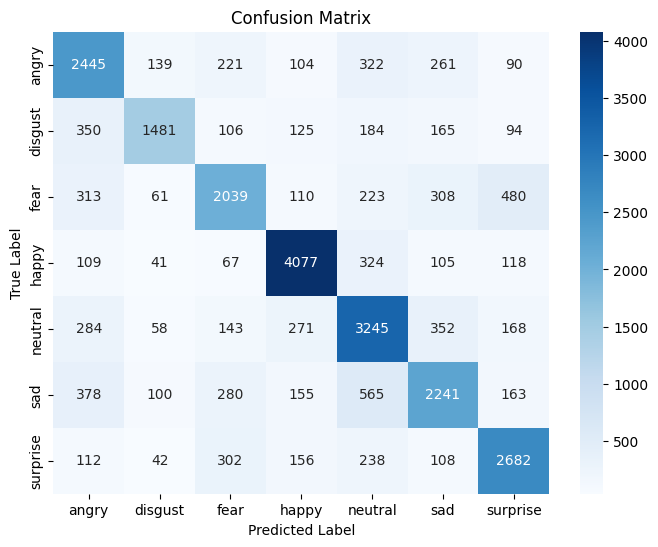

✅ Evaluation Completed! Results saved to `evaluation_results.txt` and `confusion_matrix.png`


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
from approach.ResEmoteNet import ResEmoteNet  # Ensure this matches your import structure

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# ✅ Define Transformations (Ensure Consistency with Training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Load Test Dataset
base_path = "/content/Final_Dataset"
test_dataset = datasets.ImageFolder(f"{base_path}/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# ✅ Load the Best Model
model_path = "/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth"  # Ensure this is correct
model = ResEmoteNet().to(device)

# ✅ Safe Model Loading
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    print("✅ Best Model Loaded Successfully")
except Exception as e:
    print(f"⚠️ Error loading model: {e}")

model.eval()

# ✅ Evaluate Model
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

# ✅ Compute Accuracy
test_acc = correct / total
print(f"🔥 Final Test Accuracy: {test_acc:.4f}")

# ✅ Generate Classification Report
class_labels = list(test_dataset.class_to_idx.keys())
report = classification_report(all_labels, all_preds, target_names=class_labels, digits=4)
print("\n🔎 Classification Report:\n", report)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")  # Save the matrix as an image
plt.show()

# ✅ Save Evaluation Results
with open("evaluation_results.txt", "w") as f:
    f.write(f"🔥 Final Test Accuracy: {test_acc:.4f}\n\n")
    f.write("🔎 Classification Report:\n")
    f.write(report)

print("✅ Evaluation Completed! Results saved to `evaluation_results.txt` and `confusion_matrix.png`")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report
from collections import Counter
import os

os.chdir('/content/ResEmoteNet')
from approach.ResEmoteNet import ResEmoteNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Data transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
base_path = "/content/Final_Dataset"
train_dataset = datasets.ImageFolder(f"{base_path}/train", transform=train_transform)
val_dataset = datasets.ImageFolder(f"{base_path}/val", transform=val_test_transform)
test_dataset = datasets.ImageFolder(f"{base_path}/test", transform=val_test_transform)

# Class weights for imbalance
class_counts = Counter(train_dataset.targets)
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / class_counts[i] for i in range(len(class_counts))], dtype=torch.float).to(device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load pre-trained model
model = ResEmoteNet().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth", weights_only=True))
print("✅ Pre-trained Model Loaded Successfully")

# No need to add dropout manually; model already has dropout1 (0.2) and dropout2 (0.5) before fc4
print("Note: Model already includes dropout (0.2 and 0.5) before fc4.")

# Freeze early layers
for param in model.res_block1.parameters():
    param.requires_grad = False
print("🔒 Initial layers frozen")

# Loss, optimizer, and scheduler with adjusted decay
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=7, min_lr=1e-6)  # Softer decay

# Fine-tuning function
def fine_tune_model(model, train_loader, val_loader, epochs=50, patience=10):
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                correct += (outputs.argmax(1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = correct / len(val_loader.dataset)

        print(f"📌 Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth")
            print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("🛑 Early stopping triggered!")
                break

# Run fine-tuning
print("🚀 Starting fine-tuning...")
fine_tune_model(model, train_loader, val_loader, epochs=50, patience=10)

# Test with TTA
model.load_state_dict(torch.load("/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth", weights_only=True))
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        flipped_images = torch.flip(images, [3])
        flipped_outputs = model(flipped_images)
        avg_outputs = (outputs + flipped_outputs) / 2
        preds = avg_outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = sum([1 if all_preds[i] == all_labels[i] else 0 for i in range(len(all_preds))]) / len(all_preds)
print(f"🔥 Final Test Accuracy with TTA: {test_acc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

🔥 Using device: cuda
✅ Pre-trained Model Loaded Successfully
Note: Model already includes dropout (0.2 and 0.5) before fc4.
🔒 Initial layers frozen
🚀 Starting fine-tuning...
📌 Epoch 1/50: Train Loss: 0.3865, Train Acc: 0.8665, Val Loss: 1.2544, Val Acc: 0.7077, LR: 0.000100
✅ Best model saved with Val Acc: 0.7077
📌 Epoch 2/50: Train Loss: 0.3925, Train Acc: 0.8632, Val Loss: 1.2088, Val Acc: 0.7109, LR: 0.000100
✅ Best model saved with Val Acc: 0.7109
📌 Epoch 3/50: Train Loss: 0.3937, Train Acc: 0.8649, Val Loss: 1.2074, Val Acc: 0.7100, LR: 0.000100
📌 Epoch 4/50: Train Loss: 0.3843, Train Acc: 0.8670, Val Loss: 1.2466, Val Acc: 0.7155, LR: 0.000100
✅ Best model saved with Val Acc: 0.7155
📌 Epoch 5/50: Train Loss: 0.3839, Train Acc: 0.8696, Val Loss: 1.2859, Val Acc: 0.7106, LR: 0.000100
📌 Epoch 6/50: Train Loss: 0.3780, Train Acc: 0.8703, Val Loss: 1.2862, Val Acc: 0.7132, LR: 0.000100
📌 Epoch 7/50: Train Loss: 0.3662, Train Acc: 0.8741, Val Loss: 1.2974, Val Acc: 0.7125, LR: 0.000100

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
from approach.ResEmoteNet import ResEmoteNet  # Ensure this matches your import structure

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# ✅ Define Transformations (Ensure Consistency with Training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Load Test Dataset
base_path = "/content/Final_Dataset"
test_dataset = datasets.ImageFolder(f"{base_path}/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# ✅ Load the Best Model
model_path = "/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth"  # Ensure this is correct
model = ResEmoteNet().to(device)

# ✅ Safe Model Loading
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    print("✅ Best Model Loaded Successfully")
except Exception as e:
    print(f"⚠️ Error loading model: {e}")

model.eval()

# ✅ Evaluate Model
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

# ✅ Compute Accuracy
test_acc = correct / total
print(f"🔥 Final Test Accuracy: {test_acc:.4f}")

# ✅ Generate Classification Report
class_labels = list(test_dataset.class_to_idx.keys())
report = classification_report(all_labels, all_preds, target_names=class_labels, digits=4)
print("\n🔎 Classification Report:\n", report)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")  # Save the matrix as an image
plt.show()

# ✅ Save Evaluation Results
with open("evaluation_results.txt", "w") as f:
    f.write(f"🔥 Final Test Accuracy: {test_acc:.4f}\n\n")
    f.write("🔎 Classification Report:\n")
    f.write(report)

print("✅ Evaluation Completed! Results saved to `evaluation_results.txt` and `confusion_matrix.png`")

ModuleNotFoundError: No module named 'approach'

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report
from collections import Counter
import os
import numpy as np

os.chdir('/content/ResEmoteNet')
from approach.ResEmoteNet import ResEmoteNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Data transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
base_path = "/content/Final_Dataset"
train_dataset = datasets.ImageFolder(f"{base_path}/train", transform=train_transform)
val_dataset = datasets.ImageFolder(f"{base_path}/val", transform=val_test_transform)
test_dataset = datasets.ImageFolder(f"{base_path}/test", transform=val_test_transform)

# Class weights
class_counts = Counter(train_dataset.targets)
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / class_counts[i] for i in range(len(class_counts))], dtype=torch.float).to(device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load pre-trained model
model = ResEmoteNet().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth", weights_only=True))
print("✅ Pre-trained Model Loaded Successfully")

# Freeze early layers
for param in model.res_block1.parameters():
    param.requires_grad = False
print("🔒 Initial layers frozen")

# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=7, min_lr=1e-6)

# Mixup function
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Fine-tuning function with Mixup
def fine_tune_model(model, train_loader, val_loader, epochs=50, patience=10):
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        # Training with Mixup
        model.train()
        total_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            mixed_images, y_a, y_b, lam = mixup_data(images, labels, alpha=0.2)
            optimizer.zero_grad()
            outputs = model(mixed_images)
            loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # Approximate accuracy (not exact due to Mixup)
            _, predicted = outputs.max(1)
            correct += (lam * predicted.eq(y_a).sum().item() +
                       (1 - lam) * predicted.eq(y_b).sum().item())
        train_loss = total_loss / len(train_loader)
        train_acc = correct / (len(train_loader.dataset) * 64)  # Rough estimate

        # Validation (no Mixup)
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                correct += (outputs.argmax(1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = correct / len(val_loader.dataset)

        print(f"📌 Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc (approx): {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth")
            print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("🛑 Early stopping triggered!")
                break

# Run fine-tuning
print("🚀 Starting fine-tuning...")
fine_tune_model(model, train_loader, val_loader, epochs=50, patience=10)

# Test with Enhanced TTA
model.load_state_dict(torch.load("/content/drive/MyDrive/best_finetuned_ResEmoteNet.pth", weights_only=True))
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Original
        outputs = model(images)
        # Flipped
        flipped_images = torch.flip(images, [3])
        flipped_outputs = model(flipped_images)
        # Shifted (small translation)
        shifted_images = transforms.RandomAffine(degrees=0, translate=(0.05, 0.05))(images)
        shifted_outputs = model(shifted_images)
        # Average
        avg_outputs = (outputs + flipped_outputs + shifted_outputs) / 3
        preds = avg_outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = sum([1 if all_preds[i] == all_labels[i] else 0 for i in range(len(all_preds))]) / len(all_preds)
print(f"🔥 Final Test Accuracy with Enhanced TTA: {test_acc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

🔥 Using device: cuda
✅ Pre-trained Model Loaded Successfully
🔒 Initial layers frozen
🚀 Starting fine-tuning...


KeyboardInterrupt: 

In [ ]:
!unzip /content/ExpW_sorted_gray.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/fighting_man_37_0.png  
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/hostile_student_248_4.png  
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/fierce_face_541_6.png  
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/angry_old_129_0.png  
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/hostile_girl_48_1.png  
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/fighting_european_531_0.png  
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/mad_boy_230_0.png  
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/angry_asian_265_0.png  
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/angry_boss_443_0.png  
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/fighting_man_667_0.png  
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/fierce_president_239_1.png  
  inflating: /content/ExpW_sorted_gray/ExpW_val/angry/fighting_wife_604_0.png  
  

In [ ]:
import os
import shutil
from collections import Counter

# Define paths
final_train_dir = '/content/Final_Dataset/train'
expw_train_dir = '/content/ExpW_sorted_gray/ExpW_train'
val_dir = '/content/Final_Dataset/val'
test_dir = '/content/Final_Dataset/test'

# Emotion classes
classes = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']

# Target count per class (based on max in Final_Dataset: 8606)
target_count = 8606

# Step 1: Count initial images in Final_Dataset/train
initial_counts = {}
print("Counting initial images in Final_Dataset/train:")
for cls in classes:
    cls_dir = os.path.join(final_train_dir, cls)
    initial_counts[cls] = len(os.listdir(cls_dir)) if os.path.exists(cls_dir) else 0
    print(f"  {cls}: {initial_counts[cls]} images")

# Step 2: Count available images in ExpW_train
expw_counts = {}
print("\nCounting images in ExpW_sorted_gray/ExpW_train:")
for cls in classes:
    cls_dir = os.path.join(expw_train_dir, cls)
    expw_counts[cls] = len(os.listdir(cls_dir)) if os.path.exists(cls_dir) else 0
    print(f"  {cls}: {expw_counts[cls]} images")

# Step 3: Balance Final_Dataset/train by supplementing from ExpW_train
for cls in classes:
    current_count = initial_counts[cls]
    if current_count < target_count:
        needed = target_count - current_count
        available = expw_counts[cls]
        to_add = min(needed, available)  # Add only what's needed or available

        if to_add > 0:
            src_dir = os.path.join(expw_train_dir, cls)
            dst_dir = os.path.join(final_train_dir, cls)

            # Ensure destination directory exists
            os.makedirs(dst_dir, exist_ok=True)

            # Get list of images to add
            expw_images = sorted(os.listdir(src_dir))
            images_to_add = expw_images[:to_add]

            # Copy images
            for img in images_to_add:
                src_path = os.path.join(src_dir, img)
                dst_path = os.path.join(dst_dir, img)
                # Avoid overwriting by checking if file exists
                if not os.path.exists(dst_path):
                    shutil.copy(src_path, dst_path)
                else:
                    # If file exists, append a unique suffix
                    base, ext = os.path.splitext(img)
                    i = 1
                    while os.path.exists(os.path.join(dst_dir, f"{base}_{i}{ext}")):
                        i += 1
                    shutil.copy(src_path, os.path.join(dst_dir, f"{base}_{i}{ext}"))
            print(f"Added {to_add} images to {cls} in Final_Dataset/train")

# Step 4: Count images in the balanced Final_Dataset/train
balanced_counts = {}
print("\nCounting images in balanced Final_Dataset/train:")
for cls in classes:
    cls_dir = os.path.join(final_train_dir, cls)
    balanced_counts[cls] = len(os.listdir(cls_dir)) if os.path.exists(cls_dir) else 0
    print(f"  {cls}: {balanced_counts[cls]} images")

# Total count
total_images = sum(balanced_counts.values())
print(f"\nTotal images in balanced Final_Dataset/train: {total_images}")

Counting initial images in Final_Dataset/train:
  happy: 8606 images
  sad: 6732 images
  fear: 6335 images
  surprise: 7402 images
  neutral: 8606 images
  angry: 7459 images
  disgust: 6681 images

Counting images in ExpW_sorted_gray/ExpW_train:
  happy: 12105 images
  sad: 8390 images
  fear: 2628 images
  surprise: 20153 images
  neutral: 451 images
  angry: 18105 images
  disgust: 4964 images
Added 1874 images to sad in Final_Dataset/train
Added 2271 images to fear in Final_Dataset/train
Added 1204 images to surprise in Final_Dataset/train
Added 1147 images to angry in Final_Dataset/train
Added 1925 images to disgust in Final_Dataset/train

Counting images in balanced Final_Dataset/train:
  happy: 8606 images
  sad: 8606 images
  fear: 8606 images
  surprise: 8606 images
  neutral: 8606 images
  angry: 8606 images
  disgust: 8606 images

Total images in balanced Final_Dataset/train: 60242


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
import random
from collections import Counter
from sklearn.metrics import classification_report

# Set working directory (adjust if needed)
os.chdir('/content/ResEmoteNet')
from approach.ResEmoteNet import ResEmoteNet

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Data transforms with enhanced augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),  # Convert to tensor BEFORE RandomErasing
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
base_path = "/content/Final_Dataset"
train_dataset = datasets.ImageFolder(f"{base_path}/train", transform=train_transform)
val_dataset = datasets.ImageFolder(f"{base_path}/val", transform=val_test_transform)
test_dataset = datasets.ImageFolder(f"{base_path}/test", transform=val_test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load model
model = ResEmoteNet().to(device)
try:
    model.load_state_dict(torch.load("/content/drive/MyDrive/best_finetuned_ResEmoteNet_v2.pth",
                                     map_location=device,
                                     weights_only=True))  # Secure loading
    print("✅ Pre-trained Model v2 Loaded Successfully")
except FileNotFoundError:
    print("⚠️ No pre-trained v2 model found, using default weights")

# Adjust dropout (assuming dropout2 exists before fc4)
if hasattr(model, 'dropout2'):
    model.dropout2.p = 0.6  # Increase to 0.6 for stronger regularization
    print("✅ Dropout2 increased to 0.6")
else:
    print("Warning: Could not adjust dropout. Check model structure.")

# Fine-tune deeper layers
for param in model.res_block2.parameters():
    param.requires_grad = True
for param in model.res_block3.parameters():
    param.requires_grad = True
print("🔒 res_block2 and res_block3 unfrozen for fine-tuning")

# Mixup function
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size(0)).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        per_sample_loss = -torch.sum(true_dist * pred, dim=-1)  # Shape: [batch_size]
        return torch.mean(per_sample_loss)  # Shape: scalar

# Loss, optimizer, and scheduler
criterion = LabelSmoothingLoss(classes=7, smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-2)  # Lower LR for fine-tuning
scheduler = CosineAnnealingLR(optimizer, T_max=50)

# Training function with Mixup and early stopping
def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=50, patience=10):
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            mixed_images, labels_a, labels_b, lam = mixup_data(images, labels)
            outputs = model(mixed_images)
            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (lam * (predicted == labels_a).sum().item() +
                       (1 - lam) * (predicted == labels_b).sum().item())
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)  # Corrected approximation

        model.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                correct += (outputs.argmax(1) == labels).sum().item()
        val_acc = correct / len(val_loader.dataset)

        scheduler.step()
        print(f"📌 Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc (approx): {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "/content/drive/MyDrive/best_finetuned_ResEmoteNet_v3.pth")
            print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("🛑 Early stopping triggered!")
                break

# Run training
print("🚀 Starting fine-tuning from v2...")
train_model(model, train_loader, val_loader, optimizer, scheduler)

# Test with Enhanced TTA
model.load_state_dict(torch.load("/content/drive/MyDrive/best_finetuned_ResEmoteNet_v3.pth",
                                 map_location=device,
                                 weights_only=True))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Original
        outputs = model(images)
        # Flipped
        flipped_images = torch.flip(images, [3])
        flipped_outputs = model(flipped_images)
        # Rotated (+5°)
        rotated_plus = transforms.functional.rotate(images, 5)
        rotated_plus_outputs = model(rotated_plus)
        # Rotated (-5°)
        rotated_minus = transforms.functional.rotate(images, -5)
        rotated_minus_outputs = model(rotated_minus)
        # Average
        avg_outputs = (outputs + flipped_outputs + rotated_plus_outputs + rotated_minus_outputs) / 4
        preds = avg_outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_preds)
print(f"🔥 Final Test Accuracy with Enhanced TTA: {test_acc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

🔥 Using device: cuda
✅ Pre-trained Model v2 Loaded Successfully
✅ Dropout2 increased to 0.6
🔒 res_block2 and res_block3 unfrozen for fine-tuning
🚀 Starting fine-tuning from v2...
📌 Epoch 1/50: Train Loss: 1.3515, Train Acc (approx): 0.6125, Val Acc: 0.7315, LR: 0.000010
✅ Best model saved with Val Acc: 0.7315
📌 Epoch 2/50: Train Loss: 1.3159, Train Acc (approx): 0.6290, Val Acc: 0.7308, LR: 0.000010
📌 Epoch 3/50: Train Loss: 1.2915, Train Acc (approx): 0.6410, Val Acc: 0.7351, LR: 0.000010
✅ Best model saved with Val Acc: 0.7351
📌 Epoch 4/50: Train Loss: 1.2636, Train Acc (approx): 0.6561, Val Acc: 0.7347, LR: 0.000010
📌 Epoch 5/50: Train Loss: 1.2755, Train Acc (approx): 0.6503, Val Acc: 0.7315, LR: 0.000010
📌 Epoch 6/50: Train Loss: 1.2555, Train Acc (approx): 0.6585, Val Acc: 0.7315, LR: 0.000010
📌 Epoch 7/50: Train Loss: 1.2557, Train Acc (approx): 0.6588, Val Acc: 0.7306, LR: 0.000010
📌 Epoch 8/50: Train Loss: 1.2393, Train Acc (approx): 0.6671, Val Acc: 0.7332, LR: 0.000009
📌 Epo

🔥 Using device: cuda
✅ Best Model Loaded Successfully
🔥 Final Test Accuracy with TTA: 0.7078

🔎 Classification Report:
               precision    recall  f1-score   support

       angry     0.6547    0.7178    0.6848      3582
     disgust     0.7335    0.6363    0.6815      2505
        fear     0.6663    0.5928    0.6274      3534
       happy     0.8192    0.8533    0.8359      4841
     neutral     0.6869    0.7018    0.6943      4521
         sad     0.6581    0.6242    0.6407      3882
    surprise     0.7077    0.7615    0.7336      3640

    accuracy                         0.7078     26505
   macro avg     0.7038    0.6983    0.6997     26505
weighted avg     0.7070    0.7078    0.7063     26505



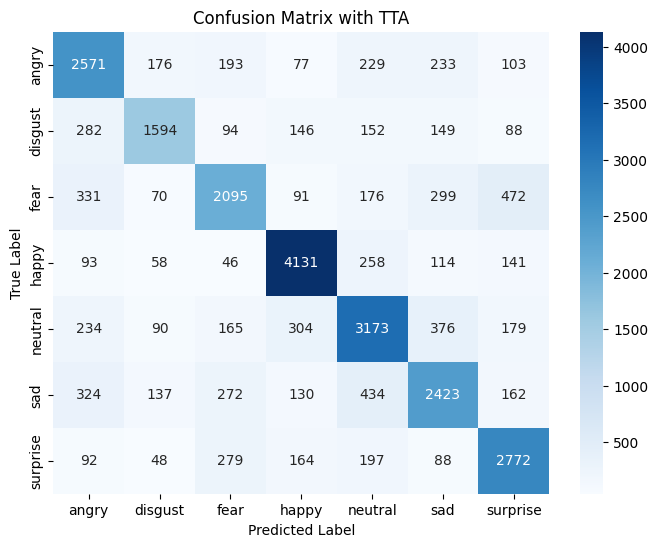

✅ Evaluation Completed! Results saved to `evaluation_results_with_tta.txt` and `confusion_matrix_with_tta.png`


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
from approach.ResEmoteNet import ResEmoteNet  # Ensure this matches your import structure

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# ✅ Define Transformations (Ensure Consistency with Training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Load Test Dataset
base_path = "/content/Final_Dataset"
test_dataset = datasets.ImageFolder(f"{base_path}/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# ✅ Load the Best Model
model_path = "/content/drive/MyDrive/best_finetuned_ResEmoteNet_v2.pth"  # Ensure this is correct
model = ResEmoteNet().to(device)

# ✅ Safe Model Loading
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    print("✅ Best Model Loaded Successfully")
except Exception as e:
    print(f"⚠️ Error loading model: {e}")

model.eval()

# ✅ Evaluate Model with TTA
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Original prediction
        outputs = model(images)
        # Flipped prediction
        flipped_images = torch.flip(images, [3])  # Horizontal flip
        flipped_outputs = model(flipped_images)
        # Rotated +5° prediction
        rotated_plus = transforms.functional.rotate(images, 5)
        rotated_plus_outputs = model(rotated_plus)
        # Rotated -5° prediction
        rotated_minus = transforms.functional.rotate(images, -5)
        rotated_minus_outputs = model(rotated_minus)
        # Average predictions across all augmentations
        avg_outputs = (outputs + flipped_outputs + rotated_plus_outputs + rotated_minus_outputs) / 4
        preds = torch.argmax(avg_outputs, dim=1)

        # Accumulate predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

# ✅ Compute Accuracy
test_acc = correct / total
print(f"🔥 Final Test Accuracy with TTA: {test_acc:.4f}")

# ✅ Generate Classification Report
class_labels = list(test_dataset.class_to_idx.keys())
report = classification_report(all_labels, all_preds, target_names=class_labels, digits=4)
print("\n🔎 Classification Report:\n", report)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with TTA")
plt.savefig("confusion_matrix_with_tta.png")  # Save with TTA label
plt.show()

# ✅ Save Evaluation Results
with open("evaluation_results_with_tta.txt", "w") as f:
    f.write(f"🔥 Final Test Accuracy with TTA: {test_acc:.4f}\n\n")
    f.write("🔎 Classification Report:\n")
    f.write(report)

print("✅ Evaluation Completed! Results saved to `evaluation_results_with_tta.txt` and `confusion_matrix_with_tta.png`")

🔥 Using device: cuda
✅ Best Model Loaded Successfully
🔥 Final Test Accuracy with TTA: 0.7073

🔎 Classification Report:
               precision    recall  f1-score   support

       angry     0.6210    0.7320    0.6720      3582
     disgust     0.7642    0.6016    0.6732      2505
        fear     0.6981    0.5843    0.6362      3534
       happy     0.8258    0.8566    0.8409      4841
     neutral     0.6787    0.7206    0.6991      4521
         sad     0.6679    0.6020    0.6332      3882
    surprise     0.6969    0.7720    0.7325      3640

    accuracy                         0.7073     26505
   macro avg     0.7075    0.6956    0.6982     26505
weighted avg     0.7094    0.7073    0.7054     26505



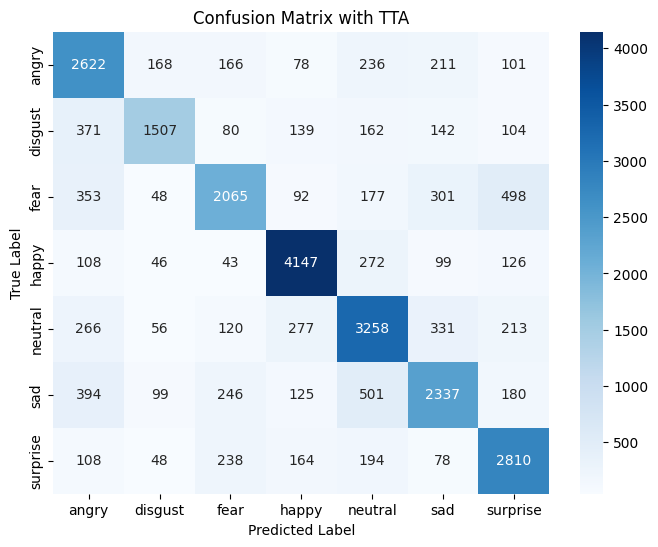

✅ Evaluation Completed! Results saved to `evaluation_results_with_tta.txt` and `confusion_matrix_with_tta.png`


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
from approach.ResEmoteNet import ResEmoteNet  # Ensure this matches your import structure

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# ✅ Define Transformations (Ensure Consistency with Training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Load Test Dataset
base_path = "/content/Final_Dataset"
test_dataset = datasets.ImageFolder(f"{base_path}/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# ✅ Load the Best Model
model_path = "/content/drive/MyDrive/best_finetuned_ResEmoteNet_v3.pth"  # Ensure this is correct
model = ResEmoteNet().to(device)

# ✅ Safe Model Loading
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    print("✅ Best Model Loaded Successfully")
except Exception as e:
    print(f"⚠️ Error loading model: {e}")

model.eval()

# ✅ Evaluate Model with TTA
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Original prediction
        outputs = model(images)
        # Flipped prediction
        flipped_images = torch.flip(images, [3])  # Horizontal flip
        flipped_outputs = model(flipped_images)
        # Rotated +5° prediction
        rotated_plus = transforms.functional.rotate(images, 5)
        rotated_plus_outputs = model(rotated_plus)
        # Rotated -5° prediction
        rotated_minus = transforms.functional.rotate(images, -5)
        rotated_minus_outputs = model(rotated_minus)
        # Average predictions across all augmentations
        avg_outputs = (outputs + flipped_outputs + rotated_plus_outputs + rotated_minus_outputs) / 4
        preds = torch.argmax(avg_outputs, dim=1)

        # Accumulate predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

# ✅ Compute Accuracy
test_acc = correct / total
print(f"🔥 Final Test Accuracy with TTA: {test_acc:.4f}")

# ✅ Generate Classification Report
class_labels = list(test_dataset.class_to_idx.keys())
report = classification_report(all_labels, all_preds, target_names=class_labels, digits=4)
print("\n🔎 Classification Report:\n", report)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with TTA")
plt.savefig("confusion_matrix_with_tta.png")  # Save with TTA label
plt.show()

# ✅ Save Evaluation Results
with open("evaluation_results_with_tta.txt", "w") as f:
    f.write(f"🔥 Final Test Accuracy with TTA: {test_acc:.4f}\n\n")
    f.write("🔎 Classification Report:\n")
    f.write(report)

print("✅ Evaluation Completed! Results saved to `evaluation_results_with_tta.txt` and `confusion_matrix_with_tta.png`")